In [1]:
import pandas as pd
import numpy as np
import nltk
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
import matplotlib.pyplot as plt 
import seaborn as sns
import time
import re

# Convert text to features
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.feature_extraction.text import CountVectorizer
# Split data to train and test
from sklearn.model_selection import train_test_split
# Classification model
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
# Binary Relevance
from sklearn.multiclass import OneVsRestClassifier
# Performance metric
from sklearn.metrics import f1_score, accuracy_score, hamming_loss

import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

### Load Data

In [2]:
movies = pd.read_csv("tmdb-movies.csv")
movies.head(2)

,id,imdb_id,popularity,budget,revenue,original_title,cast,homepage,director,tagline,...,overview,runtime,genres,production_companies,release_date,vote_count,vote_average,release_year,budget_adj,revenue_adj
0,135397,tt0369610,32.985763,150000000,1513528810,Jurassic World,Chris Pratt|Bryce Dallas Howard|Irrfan Khan|Vi...,http://www.jurassicworld.com/,Colin Trevorrow,The park is open.,...,Twenty-two years after the events of Jurassic ...,124,Action|Adventure|Science Fiction|Thriller,Universal Studios|Amblin Entertainment|Legenda...,6/9/15,5562,6.5,2015,1.379999e+08,1.392446e+09
1,76341,tt1392190,28.419936,150000000,378436354,Mad Max: Fury Road,Tom Hardy|Charlize Theron|Hugh Keays-Byrne|Nic...,http://www.madmaxmovie.com/,George Miller,What a Lovely Day.,...,An apocalyptic story set in the furthest reach...,120,Action|Adventure|Science Fiction|Thriller,Village Roadshow Pictures|Kennedy Miller Produ...,5/13/15,6185,7.1,2015,1.379999e+08,3.481613e+08


In [3]:
movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10866 entries, 0 to 10865
Data columns (total 21 columns):
id                      10866 non-null int64
imdb_id                 10856 non-null object
popularity              10866 non-null float64
budget                  10866 non-null int64
revenue                 10866 non-null int64
original_title          10866 non-null object
cast                    10790 non-null object
homepage                2936 non-null object
director                10822 non-null object
tagline                 8042 non-null object
keywords                9373 non-null object
overview                10862 non-null object
runtime                 10866 non-null int64
genres                  10843 non-null object
production_companies    9836 non-null object
release_date            10866 non-null object
vote_count              10866 non-null int64
vote_average            10866 non-null float64
release_year            10866 non-null int64
budget_adj              1

#### For this project, we would only need the id, original_title, overview and genre columns.

In [4]:
movies = movies[["id", "original_title", "overview", "genres"]]
movies.head(2)

,id,original_title,overview,genres
0,135397,Jurassic World,Twenty-two years after the events of Jurassic ...,Action|Adventure|Science Fiction|Thriller
1,76341,Mad Max: Fury Road,An apocalyptic story set in the furthest reach...,Action|Adventure|Science Fiction|Thriller


In [5]:
movies["overview"][0]

'Twenty-two years after the events of Jurassic Park, Isla Nublar now features a fully functioning dinosaur theme park, Jurassic World, as originally envisioned by John Hammond.'

In [6]:
# Check for missing values from new dataframe
movies.isnull().sum()

id                 0
original_title     0
overview           4
genres            23
dtype: int64

In [7]:
movies.shape

(10866, 4)

In [8]:
# Droping all rows with missing values
movies.dropna(axis="rows", inplace=True)

In [9]:
movies.shape

(10840, 4)

### Data Exploration and Pre-processing

In [10]:
movies["genres"][0]

'Action|Adventure|Science Fiction|Thriller'

### However, the genres are in strings notation and are seperated by pipe symbol("|"). It will be easier to work with it if we can somehow convert into python list. Let's try to do it with the first sample.

In [11]:
def to_list(x):
    return x.split("|")

In [12]:
st = time.time()
movies["genres"] = movies["genres"].apply(to_list)
et = time.time()
stop = et - st
print(stop)

0.09799909591674805


In [13]:
# Checking for genres list with empty tags
[i for i in movies["genres"] if len(i) == 0]

[]

### All movies have at least one genre tags. Let's check out the dataframe once again. 

In [14]:
movies.sample(2)

,id,original_title,overview,genres
7953,15259,Breakin',A struggling young jazz dancer (Lucinda Dickey...,[Music]
5999,201132,Antarctica: A Year on Ice,Filling the giant screen with stunning time-la...,"[Drama, Adventure, Documentary]"


In [15]:
#To check the different movie genres covered in this dataset:
all_genres = [each for x in movies["genres"] for each in x]
print(set(all_genres))

{'History', 'Family', 'Animation', 'Thriller', 'War', 'Action', 'Crime', 'Mystery', 'Fantasy', 'Comedy', 'Foreign', 'Romance', 'Horror', 'Documentary', 'Drama', 'Music', 'TV Movie', 'Science Fiction', 'Adventure', 'Western'}


### There are 20 unique genre tags in our dataset. So, let's plot out what these tags are. Instead of going through the process of  creating a dataframe then using **value_counts()** to get the count of each genre. We will use **FreqDist( )** of the nltk library to create a dictionary of genres and their occurence count across the dataset.

In [16]:
all_genres = nltk.FreqDist(all_genres)
all_genres

FreqDist({'Drama': 4761, 'Comedy': 3792, 'Thriller': 2908, 'Action': 2385, 'Romance': 1711, 'Horror': 1637, 'Adventure': 1471, 'Crime': 1355, 'Family': 1231, 'Science Fiction': 1229, ...})

In [17]:
all_genres_df = pd.DataFrame({"Genre": list(all_genres.keys()), "Count": list(all_genres.values())})

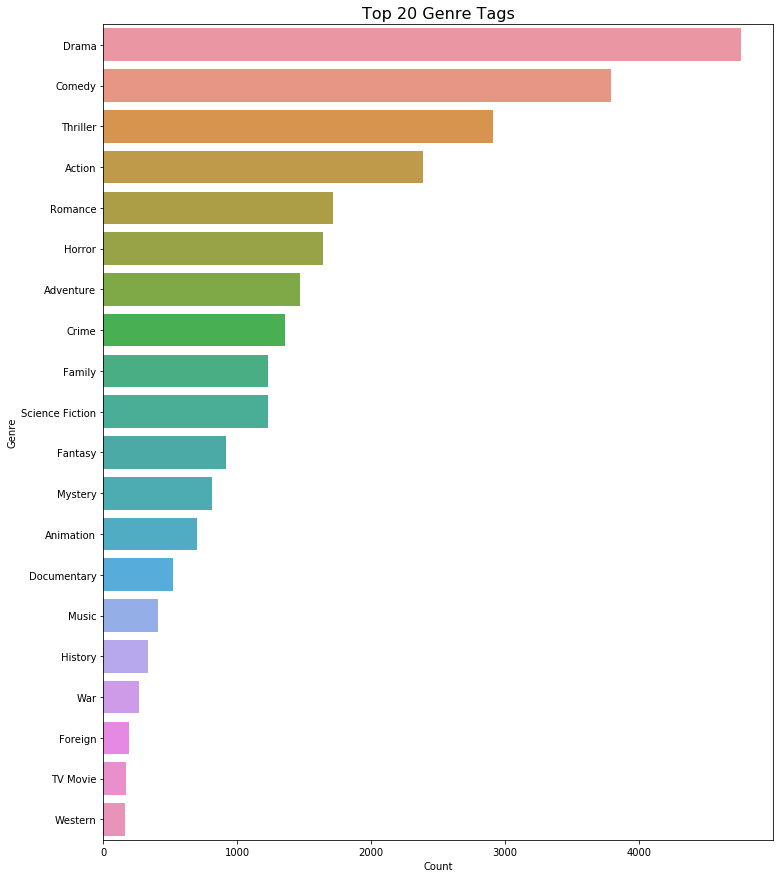

In [18]:
g = all_genres_df.nlargest(columns="Count",n=20) 
plt.figure(figsize=(12,15))
ax = sns.barplot(data=g, x= "Count", y = "Genre")
ax.set(xlabel="Count")
plt.title("Top 20 Genre Tags", fontsize=16)
plt.show()

### As expected, the most frequent tags are "Drama", "Comedy", "Thriller", and "Action".

### Next we will clean our overview column.

In [19]:
# Function for text cleaning
def clean_text(text):
    # Remove backslash-apostrophe
    text = re.sub("\'", "", text)
    # Remove everything alphabets
    text = re.sub("[^a-zA-Z]"," ",text)
    # Remove whitespaces
    text = ' '.join(text.split())
    # Convert text to lowercase
    text = text.lower()
    # Remove stop words
    stop_words = set(stopwords.words('english'))
    # There are still words that are so common like, one, two, first, second, three, go, gets and so on. 
    # Updating the stopwords
    stop_words.update(['one','two','first','second','three','four','five','six'
                       'seven','eight','nine','ten','go','gets','may','also','across',
                       'among','beside','however','yet','within','last','well'])
    stemmer = SnowballStemmer("english")
    cleaned_text = ' '.join([stemmer.stem(w) for w in text.split() if  not w in stop_words])
    return cleaned_text

In [20]:
clean_text(movies["overview"][0])

'twenti year event jurass park isla nublar featur fulli function dinosaur theme park jurass world origin envis john hammond'

In [21]:
st = time.time()
movies["overview"] = movies["overview"].apply(lambda x :clean_text(x))
et = time.time()
eslaped = et - st
print(eslaped)

17.1680006980896


In [22]:
def freq_words(col, terms = 30):
    all_words = ' '.join([text for text in col]).split()

    words = nltk.FreqDist(all_words)
    words_df = pd.DataFrame({'word':list(words.keys()), 'count':list(words.values())})

    # selecting top n most frequent words
    d = words_df.nlargest(columns="count", n = terms) 
    plt.figure(figsize=(12,15))
    ax = sns.barplot(data=d, x= "count", y = "word")
    ax.set(ylabel = 'Words')
    plt.title("Top {} Most Frequent Words in Clean_overview column".format(terms), fontsize=16)
    plt.show()

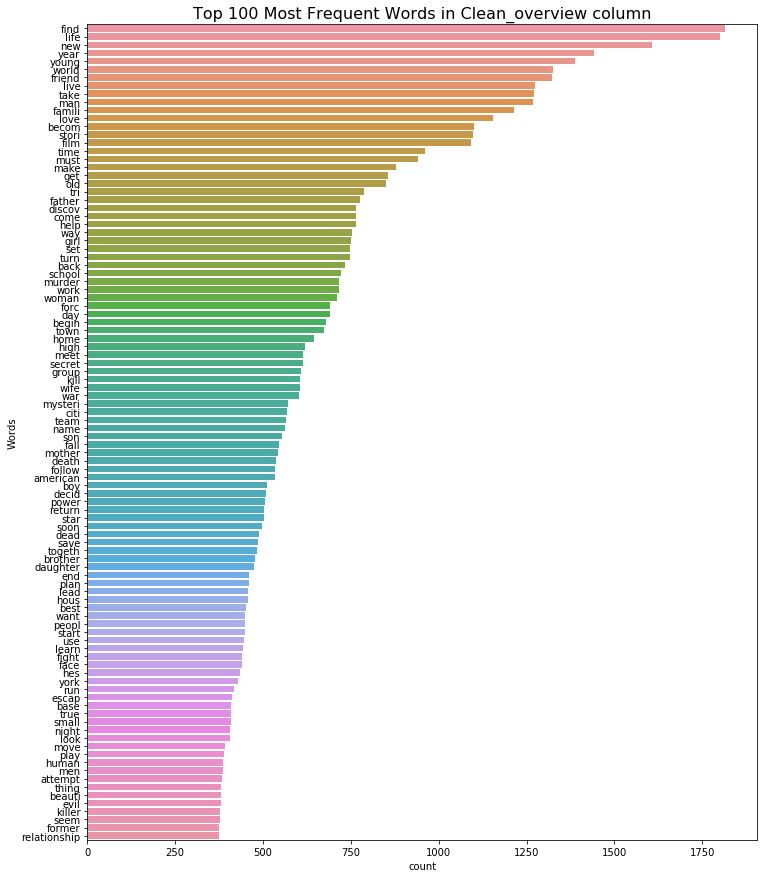

In [23]:
# print 100 most frequent words
freq_words(movies["overview"], 100)

In [24]:
# The number of words in overview list
len(' '.join([text for text in movies["overview"]]).split())

321715

### Converting Text to Features

Treating this multilable classification problem as a Binary Relevance problem. One hot Encoding the target variable by using sklearn's **MultiLabelBinarizer( )**.

In [25]:
# Instantiate the Multilabelbinarizer model
mlb = MultiLabelBinarizer()
mlb.fit(movies["genres"])

# transform target variable
y = mlb.fit_transform(movies["genres"])

Extracting features from the cleaned version of the movie overview using **CountVectorizer()** 

In [26]:
vectorizer = CountVectorizer(min_df=4,ngram_range=(1,2),binary=True)

#### - min_df is used for removing terms that appear too infrequently.
#### - Using a min_df of 4 means "ignore terms that appear in less than 4 documents".
#### -  ngram_range=(1,2) means allow words that are unigrams and bigrams
#### - for example: Let's look at this sentence: "Nigeria will be great again."
#### -  for unigrams, its splits the word into ["Nigeria","will","be","great","again"]
#### -  for bigrams, ["Nigeria will","will be","be great","great again"]

In [27]:
# split dataset into training and validation set
xtrain, xtest, ytrain, ytest = train_test_split(movies["overview"], y, test_size=0.1, random_state=42)

In [28]:
xtrain_vec = vectorizer.fit_transform(xtrain)
xtest_vec = vectorizer.transform(xtest)

### Build Movie Genre Prediction Model

In [29]:
def build_model(model,mlb_estimator,xtrain,ytrain,xtest,ytest):
    clf = mlb_estimator(model)
    clf.fit(xtrain,ytrain)
    clf_predictions = clf.predict(xtest)
    acc = accuracy_score(ytest,clf_predictions)
    f1score = f1_score(ytest, clf_predictions, average="micro")
    ham = hamming_loss(ytest,clf_predictions)
    result = {"accuracy:":acc,"f1_score":f1score,"hamming_score":ham}
    return result

 ### Use sklearn's OneVsRestClassifier class to solve this problem as a Binary Relevance or one-vs-all problem.

In [30]:
build_model(LogisticRegression(random_state=0),OneVsRestClassifier,xtrain_vec,ytrain,xtest_vec,ytest)

{'accuracy:': 0.1392988929889299,
 'f1_score': 0.526541095890411,
 'hamming_score': 0.10202952029520296}

In [31]:
build_model(DecisionTreeClassifier(random_state=0),OneVsRestClassifier,xtrain_vec,ytrain,xtest_vec,ytest)

{'accuracy:': 0.06365313653136531,
 'f1_score': 0.4282096240015585,
 'hamming_score': 0.13537822878228783}

 ### The logistic Regression model gave a higher f1_score than the DecisionTree classifier.

In [32]:
lr = LogisticRegression(random_state=0)
clf_lr = OneVsRestClassifier(lr)

In [33]:
clf_lr.fit(xtrain_vec, ytrain)

OneVsRestClassifier(estimator=LogisticRegression(random_state=0))

In [34]:
# make predictions for test set
y_pred = clf_lr.predict(xtest_vec)

Let's check out a prediction...

In [35]:
y_pred[0]

array([1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0])

Use **inverse_transform( )** function along with the MultiLabelBinarizer( ) object to convert the predicted arrays into movie genre tags.

In [36]:
mlb.inverse_transform(y_pred)[0]

('Action', 'Adventure', 'Horror', 'Thriller')

### Predict Movie Genres on new movie plots
let's build a function that will take in a movie plot text in it raws format and follow the steps below :

*   Clean the text
*   Remove stopwords from the cleaned text
*   Extract features from the text
*   Make predictions
*   Return the predicted movie genre tags




In [37]:
def predict_genre(q):
    q = text_process(q)
    q_vec = vectorizer.transform([q])
    q_pred = clf_lr.predict(q_vec)
    result = mlb.inverse_transform(q_pred)
    if len(result[0]) == 0:
        return "Sorry! Unable to Predict a Genre"
    else:
        return result

In [38]:
for i in range(5):
    k = xtest.sample(1).index[0]
    print("Movie: ", movies["original_title"][k], "\nPredicted genre: ", predict_genre(xtest[k])), print("Actual genre: ",movies["genres"][k], "\n")   

Movie:  God Help the Girl 
Predicted genre:  [('Action', 'Drama', 'Fantasy', 'Romance')]
Actual genre:  ['Comedy', 'Drama', 'Music'] 

Movie:  The Fly II 
Predicted genre:  [('Drama', 'Family', 'Science Fiction')]
Actual genre:  ['Horror', 'Science Fiction', 'Thriller'] 

Movie:  TerrorVision 
Predicted genre:  [('Drama', 'Science Fiction')]
Actual genre:  ['Horror', 'Science Fiction', 'Thriller'] 

Movie:  Generation Kill 
Predicted genre:  [('Drama',)]
Actual genre:  ['Drama', 'War', 'History'] 

Movie:  George of the Jungle 
Predicted genre:  [('Drama',)]
Actual genre:  ['Adventure', 'Comedy', 'Family', 'Romance'] 



In [39]:
text = """
Henry Biggs is the pastor of a struggling Baptist church in a poor section of New York City. His marriage to a choir singer is also failing. He gets help from an angel which enters his life."""

In [40]:
predict_genre(text)

[('Drama', 'Romance')]

In [41]:
predict_genre("transferred to Washington,")

'Sorry! Unable to Predict a Genre'

In [48]:
text = """
Princess Victoria of Kent is the heir presumptive to the British throne during the reign of her uncle King William IV and is subject to a political tug of war for influence over her. On one side is her mother, the Duchess of Kent, and the comptroller of the Duchess's household, Sir John Conroy, who tries to force Victoria to sign papers declaring a regency and giving him and her mother power if she assumes the throne while still a minor. On the other side is her uncle, King Leopold I of Belgium, who uses family ties to secure an alliance between the United Kingdom and Belgium. He wants his nephew Prince Albert of Saxe-Coburg-Gotha, who is Victoria's cousin, to marry her. Albert is then coached in Victoria's likes and dislikes. The Duchess invites the Coburg brothers, Albert and Prince Ernest of Saxe-Coburg-Gotha, to visit. Victoria and Albert develop a mutual fondness, despite Victoria knowing that their uncle sent Albert to romance her. They begin writing to one another after Albert returns home.

At a birthday reception in Windsor Castle, the King states his wish to be closer to Victoria and insults her mother. When the King increases Victoria's income, it is rejected by Conroy, who physically subdues her in front of her mother, heightening their animosity. The King then sends the Prime Minister Lord Melbourne to advise her. Victoria agrees to make Melbourne her private secretary, and he appoints her ladies-in-waiting, who are from families politically allied to him.

King William dies shortly after Victoria's 18th birthday, avoiding a regency. After accession, Victoria immediately exerts her independence, including physically distancing herself from her mother and banishing Conroy from her household and coronation. During her first meeting with the Privy Council, Victoira announces she intends to devote herself to serving her country and its people. Victoria moves into the newly-built Buckingham Palace. Her aunt, Queen Adelaide, advises her against acquiescing too much to Lord Melbourne's direction. Albert visits again, and he and Victoria further bond while discussing their mutual interest in societal issues. Victoria resists a more intimate relationship, however, and Albert leaves.

When Sir Robert Peel becomes the Prime Minister-designate, he wishes to replace some of Victoria's ladies-in-waiting with supporters of his own party. When the queen refuses, Peel rejects the queen's invitation to form a new government, allowing Melbourne to continue as Prime Minister. The subsequent crisis damages Victoria's popularity, leading to demonstrations outside the palace. The turbulence draws Victoria closer to Albert through their letters, and she invites him back to Britain. Protocol prevents him from proposing marriage, so she asks him.

Their short honeymoon is loving, but Albert soon grows frustrated at his initial powerlessness. Queen Adelaide advises Victoria to allow him to assume more duties. Albert then reorganises the royal household and dismisses Conroy for mishandling the Duchess of Kent's funds. As Victoria's primary adviser, Albert blocks Lord Melbourne and King Leopold from influencing his wife. However, he and Victoria fiercely quarrel after Albert goes over her head with Peel to replace some of her ladies-in-waiting.

When an anarchist attempts to shoot Victoria during an open-carriage ride, Albert is wounded when he shields her. His bravery leads to their reconciliation, and Melbourne urges her to share her work for social welfare with Albert. Their first child's birth helps reconcile Victoria and her mother, who had earlier sent a letter of support during the crisis.

The final title card sketches in their successful future until Albert's death at age 42."""


In [49]:
predict_genre(text)

[('Drama', 'History', 'Romance')]

In [50]:
text = """
In 2003, senior CIA official Donald Fitzroy visits a prisoner. Eight years earlier the prisoner was a minor convicted of killing his abusive father to protect his brother. Fitzroy offers the man his freedom in exchange for working as an assassin in the CIA's Sierra program.

In 2021, on a mission in Bangkok, the murderer, "Sierra Six," is working with fellow CIA agent Dani Miranda to assassinate a target suspected of selling off national security secrets. He is unable to do so stealthily without harming civilians and attacks the target directly, mortally wounding him. Before dying, the target reveals that he worked in the Sierra program as Sierra Four, and hands Six an encrypted drive detailing the corruption of CIA official Denny Carmichael, who is the lead agent on the assassination mission. Carmichael is elusive about the true purpose of the mission and the contents of the drive when confronted by Six, and Six refuses evacuation from Bangkok with Carmichael's men, calling a now-retired Fitzroy to request extraction.

Carmichael hires mercenary Lloyd Hansen, a former CIA agent kicked out of the agency for his sociopathic tendencies, to track down Six and retrieve the drive. Hansen does so by kidnapping Fitzroy's niece Claire, forcing Fitzroy to authorize Six's murder by the extraction team. However, Six kills them and escapes.

Frustrated, Carmichael sends his subordinate Suzanne Brewer to oversee Hansen and keep him in line. Hansen keeps Claire hostage in a mansion in Croatia, where he has based his operations. Hansen also puts a bounty on Six's head to attract mercenaries and assassins to hunt him down. Six heads to Vienna to find Claire's pacemaker's serial number from Laszlo Sosa, but Sosa betrays him for the bounty. Six escapes just as Hansen arrives with his team, and is rescued by Miranda. Miranda's reputation is in tatters following the Bangkok mission and she initially plans to bring him in to salvage her career at the CIA. Six convinces her to drive him to Cahill's apartment in Prague, where she decrypts the drive, which reveals the extent of Carmichael's corruption on behalf of a mysterious benefactor working for a shadow government.

Hansen sends several teams of assassins to Cahill's home, and the terminally ill Cahill blows up her home to give Six and Miranda a chance to escape. Six is arrested and handcuffed in the square. A shootout in the streets of Prague follows and Six escapes on a tram. A long chase and gun battle ensues, and Six is saved by Miranda, in Cahill's bulletproof car. The two infiltrate a hospital to track down Claire through the wireless signal broadcast from her pacemaker. The mercenary "Lone Wolf" steals the drive from them, knocking them out, and brings the drive to Hansen.

Six and Miranda follow the pacemaker to Hansen's base. Miranda creates a distraction while Six infiltrates the mansion and rescues Fitzroy and Claire. Fitzroy is mortally wounded as they flee and sacrifices himself in a failed attempt to kill Hansen. Miranda knocks out Hansen's men, but Lone Wolf narrowly escapes. He defeats Miranda in a fight but gives her the drive, having become disgusted with Hansen's willingness to kill children and his lack of morals.

Hansen manages to take Claire hostage and drags her into a hedge maze. After a standoff, Hansen lets go of Claire and fights with Six. Before Six can kill him, Hansen is shot and killed by Brewer, who tells Six that she plans to pin Carmichael's actions on Hansen in order to gain leverage over him. Furthermore, Brewer pledges Claire's safety but only if Six continues to work for the CIA. Six and Miranda are forced to co-operate in the cover-up, where ultimately no action is taken against Carmichael. After the debriefing at the CIA headquarters, Miranda threatens to kill Carmichael if any harm comes to Claire. Six escapes custody and frees Claire, who is being held at a secret location.
"""

In [52]:
predict_genre(text)

[('Action', 'Crime', 'Drama', 'Thriller')]

# The model takes in a movie plot and predicts the genre. The more detailed the movie plot is, the more accurate the predicted genres are to the actual genres.

In [48]:
import pickle
with open('model.pkl','wb') as f:
    pickle.dump(clf_lr, f)

In [49]:
pickle_in = open('model.pkl', 'rb')
model = pickle.load(pickle_in)
model

OneVsRestClassifier(estimator=LogisticRegression(random_state=0))

## Adebo Dolapo
### 5/8/2022